In [1]:
#This class reads folders and converts it into train and test split data
#import all the libraries
import re
from wordcloud import WordCloud
import pandas as pd
from pandas import DataFrame
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
import string
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import nltk

%matplotlib inline
#Note : Techniques which were tried but left due to time constraint(needed a lot of time) are commented out in complete 
#variables
input_data_folder = 'data/Enron/enron1'
different_data_folder= 'data/Enron/enron2'


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Step1: data preprocessing

#iterate through all filename present in input folder and finds whether a file is spam or not
#spam label :1, ham label : 0
def read_file_names(input_folder_path):
     path = list()
     ham_or_spam = list()
     for root, directories, filenames in os.walk(input_folder_path):
               for filename in filenames: 
                       filepath = os.path.join(root,filename)  
                       if "spam" in filename:
                                path.append(filepath)
                                ham_or_spam.append(1)
                       elif "ham" in filename:
                                path.append(filepath)
                                ham_or_spam.append(0)
     return path, ham_or_spam
                            
    #removes all non ascii characters
def remove_non_ascii(text):

    return re.sub(r'[^\x00-\x7F]',' ', text) 
 
#read file text from file path. No need for preprocessing as the data is already preprocessed
def read_file(file_path):
    file = open(file_path, 'r')
    text = file.read().strip()
    file.close()
    text = remove_non_ascii(text)
    return text.lower()
    
#creates data frame from message text and classification label
def build_data_frame(path, classification):
    rows = []
    index = []
    text = read_file(path)
    #print text
    rows.append({'message': text, 'label': classification})
    index.append(os.path.basename(path))
        
    data_frame = DataFrame(rows, index=index)
    return data_frame

#reads the complete input directoy and outputs a data frame with message and class label with filename as index 
def read_dir(input_data_folder):
    count = 0
    paths, ham_or_spam = read_file_names(input_data_folder)
    data = DataFrame({'message': [], 'label': []})
    
    for path, class_value in zip(paths, ham_or_spam):
        count = count+1
        df = build_data_frame(path, class_value)
        #print str(count)
        data = data.append(df)


    data = data.reindex(np.random.permutation(data.index))
    return data
    #print data.index.tolist()

In [3]:
#Read folder and generate test and train split
#Assumes the complete path of inputfile is provided data/Enron/Enron1 and directory structure of ham and spam
#ham is labelled as 0 and spam is labelled as 1

df =  read_dir(input_data_folder)

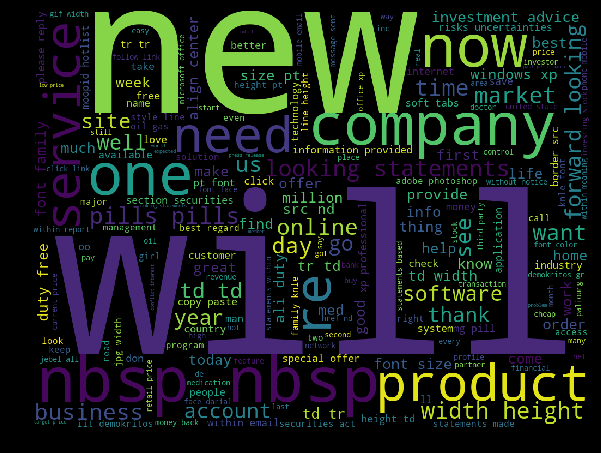

In [4]:
#Top words visualization in each category
#Visualize the spam data in a word cloud 
all_spam_message =""
for row in df.itertuples(index=True, name='Pandas'):
    label = getattr(row,'label')
    if label >0:
            all_spam_message = getattr(row, "message")+" "+all_spam_message

#replace subject from text as it is in every file
all_spam_message = all_spam_message.replace("subject"," ")
spam_word_count = WordCloud(width = 1024, height = 768).generate(all_spam_message)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_word_count)
plt.axis('off')
plt.show()


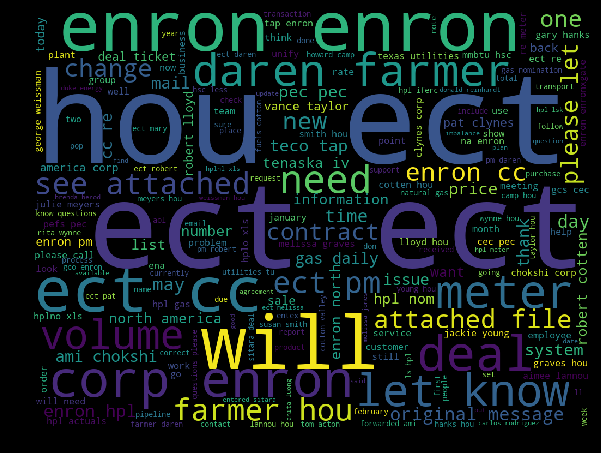

In [5]:
#Visualize the ham  data in a word cloud 
all_spam_message =""
for row in df.itertuples(index=True, name='Pandas'):
    label = getattr(row,'label')
    if label <1:
            all_spam_message = getattr(row, "message")+" "+all_spam_message
#replace subject from text as it is in every file
all_spam_message = all_spam_message.replace("subject"," ")
spam_word_count = WordCloud(width = 1024, height = 768).generate(all_spam_message)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_word_count)
plt.axis('off')
plt.show()

#Result: it can be observed that there is a clear distinguish between keywords of spam and not spam.
#Hence a classfier utlising keywords will work

In [6]:
#Makes code very slow and hence not used 
# use nltk tokenizer and stemmer for better accuracy 
#def stemming_tokenizer(text):
#    stemmer = PorterStemmer()
#    return [stemmer.stem(w) for w in word_tokenize(text)]


In [7]:
#Classification Algorithm: Naive Bayes (Reason: Bayes hypothesis should work since terms in spam and not spam are different)


text_clf_nb = Pipeline([('vect', CountVectorizer(stop_words='english' ,min_df=2)),
                      ('tfidf', TfidfTransformer()),
                      ('clf-nb', MultinomialNB(fit_prior=True,alpha = 0.05)),])
#stop_words='english',min_df=2,
# fit_prior=True, alpha = 0.05
accuracy = 0
k_fold = KFold(n=len(df), n_folds=5)
scores = []
confusion = np.array([[0, 0], [0, 0]])
for train_indices, test_indices in k_fold:
    train_text = df.iloc[train_indices]['message'].values
    train_y = df.iloc[train_indices]['label'].values

    test_text = df.iloc[test_indices]['message'].values
    test_y = df.iloc[test_indices]['label'].values
    
    text_clf_nb.fit(train_text, train_y)
    predictions = text_clf_nb.predict(test_text)

    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
    
print('Total emails classified:', len(df))
print('Average F1 Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

    

    



('Total emails classified:', 5172)
('Average F1 Score:', 0.9603405983524631)
Confusion matrix:
[[3599   73]
 [  47 1453]]


In [8]:
#Classification Algorithm: SVM (Reason: Due to High dimensional nature of NLP problems, #
#SVM performs better than most of the other algorithms. 
                                   
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english')),                     
                         ('tfidf', TfidfTransformer()),   
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=5e-4)), ])

accuracy = 0
k_fold = KFold(n=len(df), n_folds=5)
scores = []
confusion = np.array([[0, 0], [0, 0]])
for train_indices, test_indices in k_fold:
    train_text = df.iloc[train_indices]['message'].values
    train_y = df.iloc[train_indices]['label'].values

    test_text = df.iloc[test_indices]['message'].values
    test_y = df.iloc[test_indices]['label'].values
    
    text_clf_svm.fit(train_text, train_y)
    predictions = text_clf_svm.predict(test_text)

    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
   
    
print('Total emails classified:', len(df))
print('Average F1 Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

('Total emails classified:', 5172)
('Average F1 Score:', 0.98117075936522513)
Confusion matrix:
[[3624   48]
 [   9 1491]]


In [9]:
#pretty slow and hence not using it
#Classification Algorithm: Gradient Boosted Tree (Reason: Needed to check the quality of results obtained by a ensemble of decision trees
#gradient boosted tree doesnot works on sparse data. hence using Function transformation to convert it into dense format
#from sklearn.pipeline import  make_pipeline
#from sklearn.preprocessing import FunctionTransformer
#text_clf_gbt  = make_pipeline(
#     CountVectorizer(), 
#     FunctionTransformer(lambda x: x.todense(), accept_sparse=True), 
#     GradientBoostingClassifier()
#)

#accuracy = 0
#k_fold = KFold(n=len(df), n_folds=5)
#scores = []
#confusion = np.array([[0, 0], [0, 0]])
#for train_indices, test_indices in k_fold:
#    train_text = df.iloc[train_indices]['message'].values
#    train_y = df.iloc[train_indices]['label'].values

#    test_text = df.iloc[test_indices]['message'].values
#    test_y = df.iloc[test_indices]['label'].values
    
#    text_clf_gbt.fit(train_text, train_y)
#    predictions = text_clf_gbt.predict(test_text)
#
#    confusion += confusion_matrix(test_y, predictions)
#    score = f1_score(test_y, predictions, pos_label=1)
#    scores.append(score)
   
    
#print('Total emails classified:', len(df))
#print('Average F1 Score:', sum(scores)/len(scores))
#print('Confusion matrix:')
#print(confusion)


In [10]:

#Check robustness of result. How fair is the model trained on enron1 performs over enron2 
#preprocess data  in different folder
df_diff =  read_dir(different_data_folder)

In [11]:

test_diff_text = df['message'].values
test_diff_y = df['label'].values

predictions = text_clf_svm.predict(test_diff_text)
score = f1_score(test_diff_y, predictions, pos_label=1)
print ("SVM  results on different dataset"+ str(score))
print(confusion_matrix(test_diff_y, predictions))
predictions = text_clf_nb.predict(test_diff_text)
score = f1_score(test_diff_y, predictions, pos_label=1)
print ("Naive bayes  results on different dataset"+ str(score))
print(confusion_matrix(test_diff_y, predictions))
#Results: It can be observed that the model generated is not overfitting and performs similarly on other datasets also.
#I tested with enron2 to enron6 datasets. Similar results were obtained  +-2% 

SVM  results on different dataset0.991390728477
[[3649   23]
 [   3 1497]]
Naive bayes  results on different dataset0.975107865914
[[3628   44]
 [  31 1469]]
